----

## Leitura e visualização de dados:

##### Importando Bibliotecas:

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RandomizedSearchCV,  cross_validate, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer, recall_score, f1_score
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

#Ignorar Warnings nas saídas:
import warnings
warnings.simplefilter(action='ignore', category=Warning)

##### Lendo o dataframe

In [2]:
df = pd.read_csv('../Data/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


##### Verificando informações do Dataset

In [3]:
print(f"Temos {len(df.columns)} colunas nesse conjunto de dados. São elas:")
df.info()

Temos 12 colunas nesse conjunto de dados. São elas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


----

- **id:** identificador único
- **gender:** "Masculino", "Feminino" ou "Outro"
- **age:** idade do paciente
- **hypertension:** 0 se o paciente não tiver hipertensão, 1 se o paciente tiver hipertensão
- **heart_disease:** 0 se o paciente não tiver nenhuma doença cardíaca, 1 se o paciente tiver uma doença cardíaca
- **ever_married:** "Não" ou "Sim"
- **work_type:** "crianças", "Governo", "Nunca trabalhou", "Privado" ou "Autônomo"
- **Residence_type:** "Rural" ou "Urbano"
- **avg_glucose_level:** nível médio de glicose no sangue
- **bmi:** índice de massa corporal (IMC)
- **smoking_status:** status de tabagismo -> "fumante anterior", "nunca fumou", "fuma" ou "Desconhecido"*
- **stroke:** 1 se o paciente teve um derrame ou 0 se não    
**Nota: "Desconhecido" em status de tabagismo significa que a informação não está disponível para este paciente*

##### Verificando o balanceamento do Dataset:

In [4]:
balance = df['stroke'].value_counts(normalize=True)
print(f'#  Balanceamento\n1: {round(balance[1]* 100, 2)}%\n0: {round(balance[0] * 100, 2)}%')

#  Balanceamento
1: 4.87%
0: 95.13%


#### Verificação de valores nulos

In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

##### Train-test split (para evitar vazamento de dados)


In [6]:
X = df.drop(columns=['id', 'stroke'])
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42, stratify = y)

##### Correlação de cada variável (quanti) com a target

In [7]:
corr_feats_target = pd.concat([X_train, y_train], axis=1).corr()["stroke"]
corr_feats_target

age                  0.246029
hypertension         0.120188
heart_disease        0.141567
avg_glucose_level    0.123389
bmi                  0.034029
stroke               1.000000
Name: stroke, dtype: float64

##### Visualizando a distribuição dos dados em relação ao target (output)

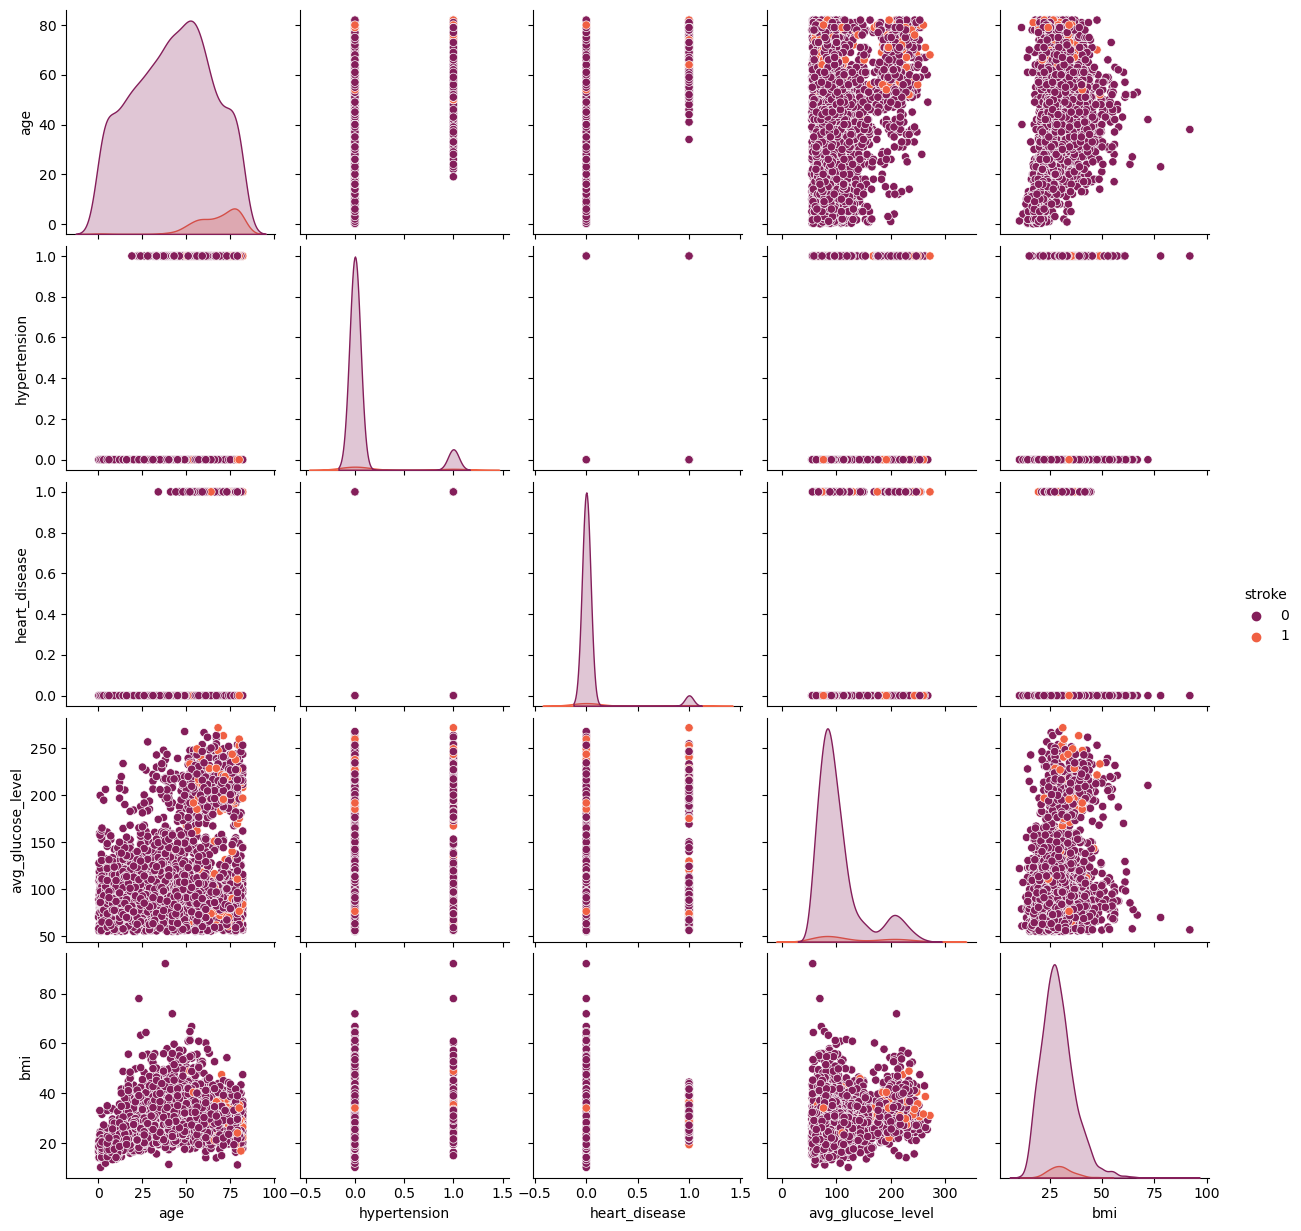

In [8]:
sns.pairplot(pd.concat([X_train, y_train], axis=1), hue='stroke', palette='rocket')

In [9]:
X_train.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi
count,3577.000000,3577.000000,3577.000000,3577.000000,3429.000000
mean,43.250433,0.096170,0.053956,105.957414,28.867279
std,22.493077,0.294865,0.225962,44.945203,7.909601
min,0.080000,0.000000,0.000000,55.120000,10.300000
25%,26.000000,0.000000,0.000000,77.460000,23.500000
50%,45.000000,0.000000,0.000000,91.710000,28.000000
75%,61.000000,0.000000,0.000000,113.630000,33.100000
max,82.000000,1.000000,1.000000,271.740000,92.000000


##### Tratando os dados:

In [10]:
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2226,52.0,0,0,107.84,22.0,0,0,1,0,0,0,0,0,1,0,0
3927,62.0,0,0,88.32,36.3,0,0,1,0,1,0,0,1,0,0,0
3358,81.0,0,1,95.49,29.4,1,0,0,0,0,1,0,0,0,0,0
4152,55.0,0,0,73.57,28.0,1,0,1,0,0,1,0,0,0,0,1
4866,37.0,0,0,103.66,36.1,0,0,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,45.0,0,0,92.86,35.1,0,0,1,0,1,0,0,1,1,0,0
461,16.0,0,0,113.47,19.5,0,0,0,0,0,0,1,0,0,0,0
1052,61.0,0,0,78.65,36.2,0,0,1,0,1,0,0,0,1,0,0
152,80.0,0,0,76.57,34.1,0,0,1,0,0,1,0,1,0,1,0


##### Correlação das features com o target pós dummies:

In [11]:
corr_feats_target_dumm = pd.concat([X_train, y_train], axis=1).corr()["stroke"]
corr_feats_target_dumm

age                               0.246029
hypertension                      0.120188
heart_disease                     0.141567
avg_glucose_level                 0.123389
bmi                               0.034029
gender_Male                      -0.003005
gender_Other                     -0.003781
ever_married_Yes                  0.112897
work_type_Never_worked           -0.013119
work_type_Private                 0.001501
work_type_Self-employed           0.071302
work_type_children               -0.085319
Residence_type_Urban              0.005964
smoking_status_formerly smoked    0.059002
smoking_status_never smoked      -0.009552
smoking_status_smokes             0.018129
stroke                            1.000000
Name: stroke, dtype: float64

#### Preenchendo os nulos:

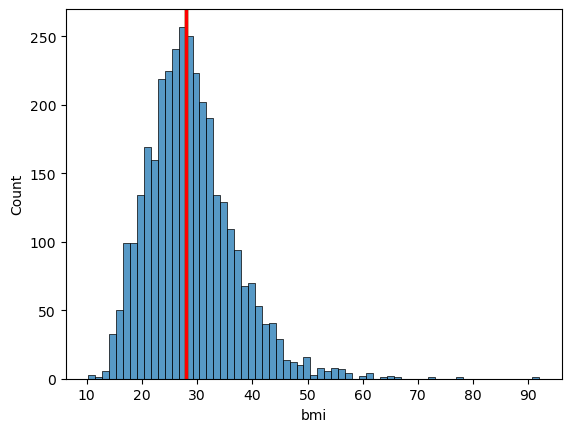

In [12]:
histrograma = sns.histplot(data=X_train['bmi'])
histrograma.axvline(x=int(X_train['bmi'].median()), c='g', ls='-', lw=2.5, label = 'Mediana')
histrograma.axvline(x=int(X_train['bmi'].mean()), c='r', ls='-', lw=2.5, label = 'Média')
plt.show()

In [13]:
bmi_median = X_train['bmi'].median()
X_train['bmi'].fillna(bmi_median, inplace=True)

In [14]:
print(X_train.isnull().sum())

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_Male                       0
gender_Other                      0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64


#### Selecionando Features:

In [15]:
select = SelectKBest(score_func = chi2)
select.fit_transform(X_train, y_train)
select.scores_

array([2.53207458e+03, 4.67008322e+01, 6.78191117e+01, 1.03797054e+03,
       5.62428695e+00, 1.89104942e-02, 5.11313547e-02, 1.54987486e+01,
       6.13576256e-01, 3.45199131e-03, 1.51908175e+01, 2.25368432e+01,
       6.31055813e-02, 1.02557826e+01, 2.05302251e-01, 9.99835658e-01])

In [16]:
colunas_filtradas = select.get_support()
X_train = X_train[X_train.columns[colunas_filtradas]]
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married_Yes,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_smokes
2226,52.0,0,0,107.84,22.0,1,0,0,1,0
3927,62.0,0,0,88.32,36.3,1,0,0,0,0
3358,81.0,0,1,95.49,29.4,0,1,0,0,0
4152,55.0,0,0,73.57,28.0,1,1,0,0,1
4866,37.0,0,0,103.66,36.1,1,0,0,0,1


#### Verificando Outliers:

In [17]:
X_train.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married_Yes,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_smokes
count,3577.000000,3577.000000,3577.000000,3577.000000,3577.000000,3577.000000,3577.000000,3577.000000,3577.000000,3577.000000
mean,43.250433,0.096170,0.053956,105.957414,28.831395,0.660050,0.164663,0.134470,0.176405,0.149567
std,22.493077,0.294865,0.225962,44.945203,7.746121,0.473758,0.370928,0.341205,0.381217,0.356696
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,0.000000,0.000000,77.460000,23.700000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,0.000000,91.710000,28.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,0.000000,0.000000,113.630000,32.700000,1.000000,0.000000,0.000000,0.000000,0.000000
max,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000


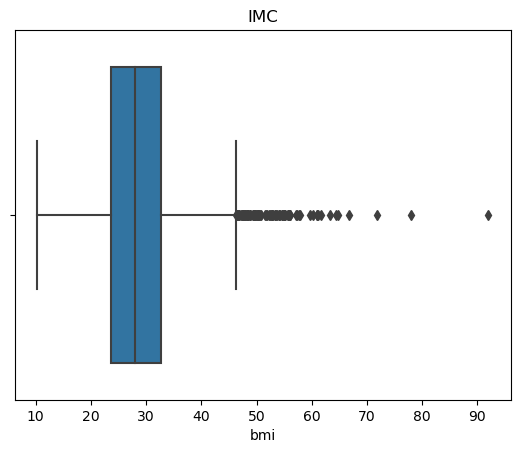

In [18]:
sns.boxplot(x=X_train["bmi"]).set_title("IMC")

plt.show()

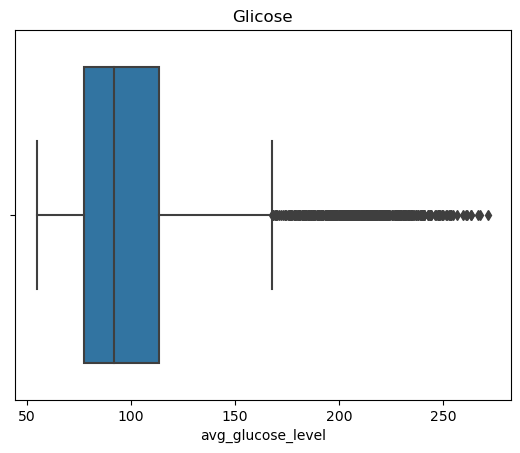

In [19]:
sns.boxplot(x=X_train["avg_glucose_level"]).set_title("Glicose")

plt.show()

#### Modelo 1 - Ada Boosting sem Retirada de Outliers e sem rebalanceamento de classes

In [20]:
lista_etapas = [("std_scaler", StandardScaler()), 
                ("ab", AdaBoostClassifier(random_state=42))]

pipe = Pipeline(lista_etapas).fit(X_train, y_train)

grupo = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(f1_score, pos_label=1)

results = cross_validate(estimator = pipe,
              X=X_train, y=y_train,
              cv=grupo, scoring=metrica)

df_results = pd.DataFrame(results)


Métricas de avaliação de treino:


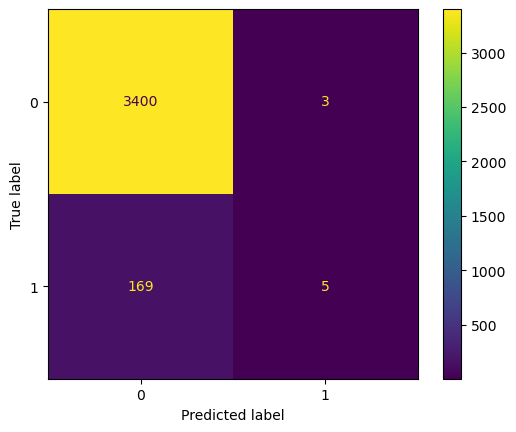

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3403
           1       0.62      0.03      0.05       174

    accuracy                           0.95      3577
   macro avg       0.79      0.51      0.52      3577
weighted avg       0.94      0.95      0.93      3577



In [22]:
print("\nMétricas de avaliação de treino:")

y_pred_train = pipe.predict(X_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

In [23]:
print("\n Transformando os dados de teste:")

categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

bmi_median_test = X_test['bmi'].median()
X_test['bmi'].fillna(bmi_median_test, inplace=True)

X_test = X_test[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'ever_married_Yes', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked', 'smoking_status_smokes' ]]
X_test


 Transformando os dados de teste:


,age,hypertension,heart_disease,avg_glucose_level,bmi,ever_married_Yes,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_smokes
4223,52.0,0,0,59.62,50.8,1,1,0,0,0
2230,8.0,0,0,89.57,18.8,0,0,1,0,0
4612,30.0,0,0,105.08,25.5,0,0,0,0,0
4100,17.0,0,0,109.39,26.3,0,0,0,0,0
2983,31.0,0,0,69.26,21.8,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1765,5.0,0,0,70.00,18.6,0,0,1,0,0
3103,66.0,0,0,88.83,29.1,1,0,0,0,0
4522,52.0,1,0,116.62,28.3,1,0,0,0,1
624,65.0,0,1,58.37,28.0,1,1,0,0,1



Métricas de avaliação de teste:


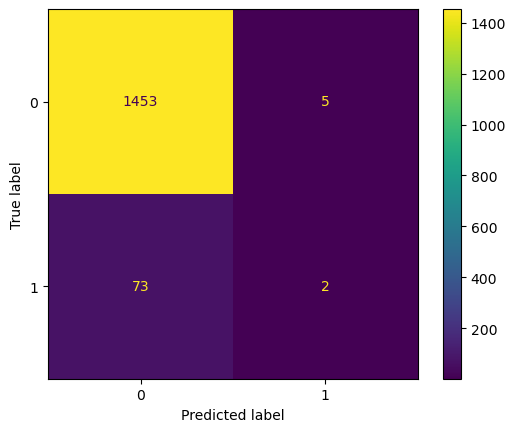

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1458
           1       0.29      0.03      0.05        75

    accuracy                           0.95      1533
   macro avg       0.62      0.51      0.51      1533
weighted avg       0.92      0.95      0.93      1533



In [24]:
# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test = pipe.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

#### Modelo 2 - Ada Boosting sem Retirada de Outliers e com rebalanceamento de classes

In [26]:
model=AdaBoostClassifier()

sme=SMOTEENN(random_state=42)

X_res, y_res = sme.fit_resample(X_train, y_train)


In [27]:
lista_etapas = [("std_scaler", StandardScaler()), 
                ("ab", AdaBoostClassifier(random_state=42))]

pipe_res = Pipeline(lista_etapas).fit(X_res, y_res)

grupo = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica = make_scorer(f1_score, pos_label=1)

results = cross_validate(estimator = pipe_res,
              X=X_res, y=y_res,
              cv=grupo, scoring=metrica)

df_results = pd.DataFrame(results)


Métricas de avaliação de treino:


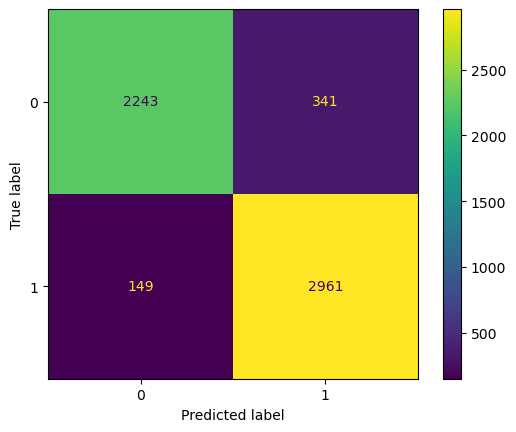

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      2584
           1       0.90      0.95      0.92      3110

    accuracy                           0.91      5694
   macro avg       0.92      0.91      0.91      5694
weighted avg       0.92      0.91      0.91      5694



In [28]:
print("\nMétricas de avaliação de treino:")

y_pred_train_res = pipe_res.predict(X_res)

ConfusionMatrixDisplay.from_predictions(y_res, y_pred_train_res)
plt.show()

print(classification_report(y_res, y_pred_train_res))


Métricas de avaliação de teste:


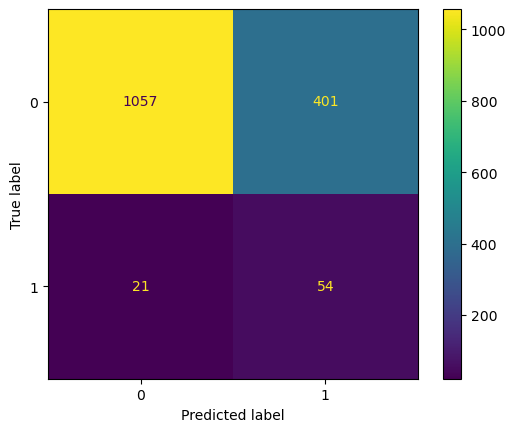

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      1458
           1       0.12      0.72      0.20        75

    accuracy                           0.72      1533
   macro avg       0.55      0.72      0.52      1533
weighted avg       0.94      0.72      0.80      1533



In [31]:
# ============================================

print("\nMétricas de avaliação de teste:")

y_pred_test_res = pipe_res.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_res)
plt.show()

print(classification_report(y_test, y_pred_test_res))

In [ ]:
##Ou eu errei algo muito grande com o rebalanceamento ou sei la, pós rebalanceamento ficou pior hahaha


---------------------

##### Importando bibliotecas necessárias:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

##### Realizando o Split:

In [ ]:
X = df.drop(columns=['id', 'stroke'])
y = df['stroke']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, 
                                                    random_state = 42)

In [ ]:
X_train.describe()

In [ ]:
df_limpeza = pd.concat([X_train, y_train], axis=1) 
df_limpeza

In [ ]:
df_limpeza = df_limpeza[df_limpeza['bmi'] < 60]
df_limpeza.head()

In [ ]:
sns.histplot(data=df_limpeza['avg_glucose_level'])

In [ ]:
y_train = df_limpeza['stroke']
X_train = df_limpeza.drop(columns=['stroke'])
X_train.head()

In [ ]:
# lembrar de trocar os True e False por 1 e 0
#X_train.replace(inplace=True)

####
----
####

#### Preparando a predição:

##### Importando as bibliotecas necessárias

In [ ]:
#Scalers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
#Kfold
from sklearn.model_selection import KFold, StratifiedKFold

#Grid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#Scorers
from sklearn.metrics import recall_score, f1_score, precision_score, make_scorer, accuracy_score

#Estimador:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LinearRegression

##### Definindo o Scaler:

##### Organizando o Pipeline:

In [ ]:
'''
lista_etapas = Pipeline([('knn', KNeighborsClassifier())])

#Define pipeline
pipeline = Pipeline(steps=lista_etapas)

#Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Evaluate model
scoring=['accuracy','precision_macro','recall_macro']
scores = cross_validate(pipeline, X, Y, scoring=scoring, cv=cv, n_jobs=-1)
'''

In [ ]:
lista_etapas_crua = [("std_scaler", StandardScaler()), 
                ("knn", KNeighborsClassifier())]

pipe_cru = Pipeline(lista_etapas_crua)

splitter_cru = KFold(n_splits=10, shuffle=True, random_state=42)

accuracy_cru = make_scorer(accuracy_score)

##### Organizando o Grid:

In [ ]:
param_grid = {"knn__weights" : ["distance", "uniform"],
              "knn__algorithm" : ['ball_tree', 'kd_tree', 'brute'],
              "knn__metric" : ["manhattan", "euclidean", "minkowski"],
              "knn__n_neighbors" : range(3, 100)}

rs_knn = RandomizedSearchCV(estimator=pipe_cru, 
                        param_distributions=param_grid,
                        scoring=accuracy_cru, ## Agora é um dict com as metricas
                        cv=splitter_cru,
                        n_iter=40,
                        verbose=10) ## Criterio de qual é o melhor modelo entre as metricas

rs_knn.fit(X_train, y_train)
y_pred_test = rs_knn.predict(X_test)

####
----
####

#### Visualização de resultados:

##### Importando bibliotecas necessárias:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

##### Visualizando resultados:

In [ ]:
print(confusion_matrix(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.show()

print(classification_report(y_test, y_pred_test))

print("\n# ====================\n")

y_pred_train = rs_knn.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))

ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
plt.show()

print(classification_report(y_train, y_pred_train))

####
----
####

#### Conclusões:

# teste gabi

####
----
####